In [1]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

In [2]:
traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
net = AlexNet()

In [11]:
summary(net, (1, 1, 152), 256, device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 64, 1, 73]             512
              ReLU-2           [256, 64, 1, 73]               0
         MaxPool2d-3           [256, 64, 1, 36]               0
            Conv2d-4          [256, 192, 1, 32]          61,632
              ReLU-5          [256, 192, 1, 32]               0
         MaxPool2d-6          [256, 192, 1, 15]               0
            Conv2d-7          [256, 384, 1, 13]         221,568
              ReLU-8          [256, 384, 1, 13]               0
            Conv2d-9          [256, 256, 1, 11]         295,168
             ReLU-10          [256, 256, 1, 11]               0
           Conv2d-11           [256, 256, 1, 9]         196,864
             ReLU-12           [256, 256, 1, 9]               0
        MaxPool2d-13           [256, 256, 1, 4]               0
           Linear-14                [25

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

In [7]:
def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

loss 0.693, train acc 0.517, test acc 0.533


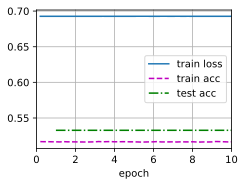

In [12]:
lr = 0.2
epochs = 10
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [ ]:
# from lib.jianji.code_csf import csf
# import torch 
# from torch.utils.data import Dataset
# from torch import nn
# from torchsummary import summary
# from d2l import torch as d2l

# traindSet = csf(csv_path='original_train_set.pkl', mode='train')
# trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
# testset = csf(csv_path='original_valid_set.pkl', mode='valid')
# testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()

# print(net.features[1].weight.requires_grad)

# summary(net, (1, 1, 152), 256, device = 'cpu')

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            # for name, parms in net.named_parameters():	
            #     print('-->name:', name)
            #     print('-->para:', parms)
            #     print('-->grad_requirs:',parms.requires_grad)
            #     print('-->grad_value:',parms.grad)
            #     print("==="*50)
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            # print('*'*100)
            # print([x.grad for x in optimizer.param_groups[0]['params']])
            global temp
            # print('*'*100)
            temp += 1
            if temp>1:
                break
            optimizer.step()
            print('#'*150)
            # for name, parms in net.named_parameters():	
            #     print('-->name:', name)
            #     print('-->para:', parms)
            #     print('-->grad_requirs:',parms.requires_grad)
            #     print('-->grad_value:',parms.grad)
            #     print("==="*50)
            # print('输出优化器')
            # print(optimizer)
            # print('输出结束')
            # print('&'*100)
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
        # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        #   f'test acc {test_acc:.3f}')


lr = 5
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
temp = 0
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.BatchNorm1d(2048),
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout(p=dropout),
            # nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(512, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(64, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                len = X.shape[0]
                if (i+1) % 100 == 0:
                    print(l)
        #         metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
        #     train_l = metric[0] / metric[2]
        #     train_acc = metric[1] / metric[2]
        #     if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        #         animator.add(epoch + (i + 1) / num_batches,
        #                      (train_l, train_acc, None))
        # test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
        # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        #   f'test acc {test_acc:.3f}')


lr = 0.3
epochs = 10
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
temp = 0
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [5]:
torch.save(net,'Alexnet.pth')

In [ ]:
torch.save(net,'Alexnet.pth')
net1 = torch.load('Alexnet.pth')
net1.eval()
i = 0
for X, y in trainloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net1(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

In [6]:
net1 = torch.load('Alexnet.pth')

In [13]:
net1.eval()
i = 0
for X, y in trainloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net1(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

237.0
244.0
242.0
244.0
246.0
246.0
245.0
241.0
244.0
243.0


In [7]:
d2l.accuracy??

Signature: d2l.accuracy(y_hat, y)
Source:   
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))
File:      c:\users\jiang su\.conda\envs\pytorch\lib\site-packages\d2l\torch.py
Type:      function